## Réseau Neurones Convolutif - Lettres

#### 1. Imporation Library

In [ ]:
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from sklearn import metrics

import itertools

: 

#### 2. Load dataset EMNIST (fichiers CSV d'images de lettres)

In [2]:
train_data_letters = pd.read_csv('emnist-letters-train.csv', header=None)
test_data_letters = pd.read_csv('emnist-letters-test.csv', header=None)

# Divisez les données en caractéristiques (pixels) et étiquettes
X_train = train_data_letters.iloc[:, 1:].values
y_train = train_data_letters.iloc[:, 0].values

X_test = test_data_letters.iloc[:, 1:].values
y_test = test_data_letters.iloc[:, 0].values

# Redimensionnez les données
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

#### 3. Normalisation des vecteurs train et test

In [3]:
# Normalisez les valeurs des pixels
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

num_classes = 27  # 27 lettres de l'alphabet plus une classe pour les caractères inconnus
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#### 4. Génération d'images

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

#### 5. Callbacks

In [5]:
from keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [6]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%,
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer
                                    verbose=1)

time_callback = TimingCallback()

#### 6. Architecture du modèle

In [7]:
model_letters = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(rate=0.5),  # Augmentation du taux de dropout
    layers.Dense(128, activation='relu'),
    layers.Dense(27, activation='softmax')
])

# Compilation du modèle
model_letters.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec augmentation des données
history = model_letters.fit(datagen.flow(X_train, y_train, batch_size=200),
                            steps_per_epoch=len(X_train) / 200,  # Nombre d'itérations par epoch
                            epochs=30,  # Augmentation du nombre d'epochs
                            validation_data=(X_test, y_test),
                            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback],
                        verbose=True)

Epoch 1/30
444/444 [==============================] - 15s 32ms/step - loss: 1.6313 - accuracy: 0.4967 - val_loss: 0.7751 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 2/30
444/444 [==============================] - 14s 31ms/step - loss: 0.9576 - accuracy: 0.6950 - val_loss: 0.5668 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 3/30
444/444 [==============================] - 13s 30ms/step - loss: 0.7793 - accuracy: 0.7492 - val_loss: 0.5404 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 4/30
444/444 [==============================] - 13s 30ms/step - loss: 0.6830 - accuracy: 0.7790 - val_loss: 0.4486 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 5/30
444/444 [==============================] - 13s 30ms/step - loss: 0.6249 - accuracy: 0.7980 - val_loss: 0.4525 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 6/30
444/444 [==============================] - 13s 30ms/step - loss: 0.5814 - accuracy: 0.8103 - val_loss: 0.3934 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 7/30
444/444 [==============================] - 13s 

#### 7. Affichage de la performance du modèle

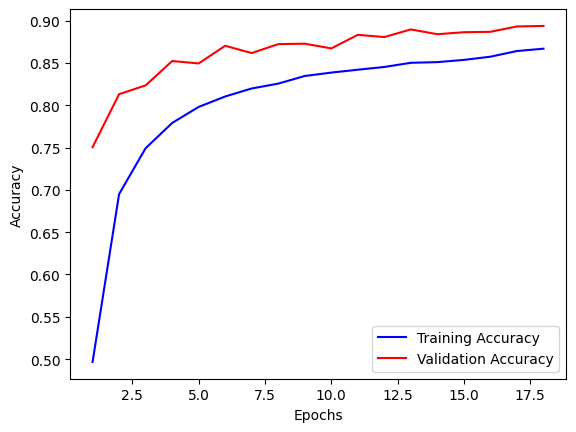

In [9]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 19, 1),
         history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 19, 1),
         history.history['val_accuracy'],
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

#### 8. Réussite du modèle sur des nouvelles images (ici, accuracy = 90% de réussite)

In [12]:
test_pred = model_letters.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

print(metrics.classification_report(y_test_class, test_pred_class))

463/463 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           1       0.94      0.91      0.92       800
           2       0.89      0.90      0.89       800
           3       0.98      0.94      0.96       800
           4       0.90      0.93      0.91       800
           5       0.94      0.96      0.95       800
           6       0.97      0.94      0.95       800
           7       0.90      0.75      0.82       800
           8       0.94      0.92      0.93       800
           9       0.77      0.67      0.72       800
          10       0.97      0.93      0.95       800
          11       0.97      0.97      0.97       800
          12       0.71      0.77      0.74       800
          13       0.97      0.92      0.94       800
          14       0.97      0.90      0.93       800
          15       0.98      0.92      0.95       800
          16       0.88      0.93      0.91       800
          17       0.75   

C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetri

#### 9. Sauvegarde du modèle

In [10]:
model_letters.save("Trained_models/CNN_Letters.h5")

C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 10. Exemple de prédictions réussites du modèle

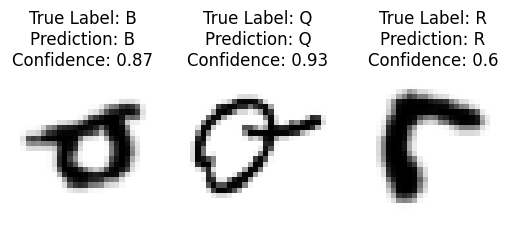

In [13]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
right_indexes = []
for i in range(len(test_pred)):
    if (test_pred_class[i] == y_test_class[i]):
                right_indexes += [i]

j = 1
for i in np.random.choice(right_indexes, size = 3):
    img = X_test[i]
    img = img.reshape(28, 28)

    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + alphabet[y_test_class[i]-1] \
              + '\n' + 'Prediction: '+ alphabet[test_pred_class[i]-1] \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][test_pred_class[i]], 2)))

#### 11. Exemple d'erreur de prédictions du modèle

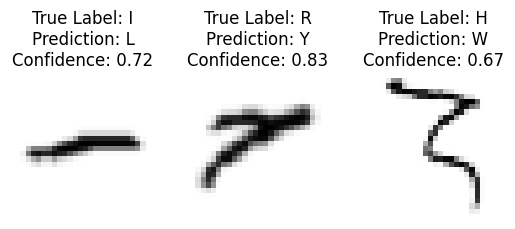

In [14]:
error_indexes = []
for i in range(len(test_pred)):
    if (test_pred_class[i] != y_test_class[i]):
                error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 3):
    img = X_test[i]
    img = img.reshape(28, 28)

    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + alphabet[y_test_class[i]-1] \
              + '\n' + 'Prediction: '+ alphabet[test_pred_class[i]-1] \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][test_pred_class[i]], 2)))

Autres tests